# Notebook d'approche non supervisé (LDA, Keras, BERT)

# Projet 5

In [1]:
#Import les libriries 

import re
import nltk
import time
import string

import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import manifold
from bs4 import BeautifulSoup
from scipy.sparse import hstack

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from nltk.stem.porter import PorterStemmer   

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer



# import module nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bleye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bleye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bleye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bleye\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Création d'un df origine 
df_origine = pd.read_csv("QueryResults.csv")

In [3]:
# creation d'une copie du df origine afin de garder une copie du df original en cas de besoin
df = df_origine.copy()

In [4]:
df.head(5)

Title  \
0            How to convert Decimal to Double in C#?   
1  Why did the width collapse in the percentage w...   
2  How do I calculate someone's age based on a Da...   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                Body  \
0  <p>I want to assign the decimal variable &quot...   
1  <p>I have an absolutely positioned <code>div</...   
2  <p>Given a <code>DateTime</code> representing ...   
3  <p>Given a specific <code>DateTime</code> valu...   
4  <p>Is there a standard way for a web server to...   

                                                Tags  
0  <c#><floating-point><type-conversion><double><...  
1                   <html><css><internet-explorer-7>  
2                                     <c#><datetime>  
3  <c#><datetime><time><datediff><relative-time-s...  
4  <html><browser><timezone><user-agent><timezone...

In [5]:
# Vérification des valeirs manquantes
df.isnull().sum()

Title      0
Body       0
Tags     109
dtype: int64

Notre df comporte 3 colonnes, Title, Body, et Tags. Nous pouvons voir que la colonnes tags comporte 109 valeurs manquantes

In [6]:
def recupTag(df):

    # Créer une liste pour stocker les premiers tags
    """ Cette fonction sert a récupérer le premier tags de la ligne, car certains tags ne sont presents que très peu de fois. 
    Puis de mettre ces tags triés dans une nouvelle colonne nommer "new_tags"
    """ #help(recupTag)
    
    list_ = []
    for tags in df['Tags']:
        try:
            # Séparer les tags et garder le premier, retirer les caractères '<' et '>'
            first_tag = tags.split('><')[0].replace('<', '').replace('>', '')
            list_.append(first_tag)
        except:
            # si 'tags' = 'NaN', ajouter 'vide'
            list_.append('vide')

    # Ajoute les premiers tags dans une nouvelle colonne du DataFrame
    df['new_tags'] = list_
    return df

In [7]:
# Application de la fonction recuptags
df = recupTag(df)

In [8]:
# vérification
df.head(5)

Title  \
0            How to convert Decimal to Double in C#?   
1  Why did the width collapse in the percentage w...   
2  How do I calculate someone's age based on a Da...   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                Body  \
0  <p>I want to assign the decimal variable &quot...   
1  <p>I have an absolutely positioned <code>div</...   
2  <p>Given a <code>DateTime</code> representing ...   
3  <p>Given a specific <code>DateTime</code> valu...   
4  <p>Is there a standard way for a web server to...   

                                                Tags new_tags  
0  <c#><floating-point><type-conversion><double><...       c#  
1                   <html><css><internet-explorer-7>     html  
2                                     <c#><datetime>       c#  
3  <c#><datetime><time><datediff><relative-time-s...       c#  
4  <html><browser><timezone><user-agent><timezone...     html

la nouvelle colonne "new_tags" à bien été creer

In [9]:
df.sample(5)

Title  \
44640  How do I create a new row in WPF DataGrid when...   
42803  "new BigDecimal(13.3D)" results in imprecise "...   
10439  What is the best SQL library for use in Common...   
27037  Using Web.SiteMap with Dynamic URLS (URL Routing)   
14839                           User32 API calls in .NET   

                                                    Body  \
44640  <p>I have a project with an XmlDataProvider bo...   
42803  <p>How is it that Java's <code>BigDecimal</cod...   
10439  <p>Ideally something that will work with Oracl...   
27037  <p>I would like to match &quot;approximate&quo...   
14839  <p>I'm currently planning out a project involv...   

                                                    Tags new_tags  
44640             <c#><wpf><wpftoolkit><xmldataprovider>       c#  
42803                      <java><precision><bigdecimal>     java  
10439     <sql><database><postgresql><lisp><common-lisp>      sql  
27037  <mapping><url-routing><sitemap><wildcard><site...  mapping  
14839                                  <managed><user32>  managed

In [10]:
df.tail(5)

Title  \
46492                      Flash loads twice workaround?   
46493  How do you create python methods(signature and...   
46494                             ETag vs Header Expires   
46495  How do I determine the longest similar portion...   
46496          How do you validate a binary search tree?   

                                                    Body  \
46492  <p>While investigating a reported problem with...   
46493  <p>I've created a method that generates a new ...   
46494  <p>I've looked around but haven't been able to...   
46495  <p>As per the title, I'm trying to find a way ...   
46496  <p>I read on here of an exercise in interviews...   

                                                   Tags   new_tags  
46492                                <flash><swfobject>      flash  
46493        <python><django><dynamic><methods><lambda>     python  
46494             <http><caching><etag><expires-header>       http  
46495             <perl><algorithm><string><similarity>       perl  
46496  <algorithm><data-structures><binary-search-tree>  algorithm

In [11]:
# supprime les lignes qui contiennent le mot 'vide' dans la colonne 'new_tags'
df= df[df["new_tags"]!= 'vide']

In [12]:
# Vérification qu'il n'y a plus de valeurs manquantes
df.isnull().sum()

Title       0
Body        0
Tags        0
new_tags    0
dtype: int64

mon df ne contient plus aucunes données manquantes

# Information dataset

In [13]:
# nombre de lignes et de colonnes
df.shape

(46388, 4)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46388 entries, 0 to 46496
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     46388 non-null  object
 1   Body      46388 non-null  object
 2   Tags      46388 non-null  object
 3   new_tags  46388 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [15]:
df.dtypes

Title       object
Body        object
Tags        object
new_tags    object
dtype: object

In [16]:
# Nombre de tags uniques
len(df['new_tags'].unique())

1442

mon df contient 1442 tags differents

# DataCleaning

Le datacleaning en nlp comprends :

    - Recuperer le code entre les balises html
    - Mettre le texte en minuscule
    - Supprimer les liens https
    - Supprimer les ponctuations
    - Supprimer les chiffres (sauf si les chiffres ont un intérêt)
    - Tokenisation (garder la racine des mots)
    - Supprimer les stop word 

In [17]:
def preprocess_text(text):
    # Récupère le text entre les balises html
    text = BeautifulSoup(text).get_text()
    # Converti en minuscules
    text = text.lower()
    # Supprime les liens
    text = re.sub(r'https?\S+', ' ', text)
    # Supprime les ponctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Supprime les chiffres
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Supprime les stopwords engish
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def preprocess_dataset(dataset, text_columns):
    for col in text_columns:
        dataset[col] = dataset[col].apply(preprocess_text)
    return dataset

def apply_stemming_lemmatization(tokens):
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stemmed = [ps.stem(word) for word in tokens]
    lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]
    return lemmatized

def preprocess_and_transform(dataset):
    # Appliquer le prétraitement
    text_columns = ['Title', 'Body', 'new_tags']
    dataset = preprocess_dataset(dataset, text_columns)
    # Appliquer le stemming et lemmatization
    for col in text_columns:
        dataset[col] = dataset[col].apply(apply_stemming_lemmatization)
    return dataset

In [18]:
#creation d'une copy de df pour pourvoir mettre ce df brut directement dans le modele bert utiliser plus tard
df_bert = df.drop(columns=['Tags'])

In [19]:
# vérification df bert 
df_bert.head(5)

Title  \
0            How to convert Decimal to Double in C#?   
1  Why did the width collapse in the percentage w...   
2  How do I calculate someone's age based on a Da...   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                Body new_tags  
0  <p>I want to assign the decimal variable &quot...       c#  
1  <p>I have an absolutely positioned <code>div</...     html  
2  <p>Given a <code>DateTime</code> representing ...       c#  
3  <p>Given a specific <code>DateTime</code> valu...       c#  
4  <p>Is there a standard way for a web server to...     html

In [20]:
df.head(5)

Title  \
0            How to convert Decimal to Double in C#?   
1  Why did the width collapse in the percentage w...   
2  How do I calculate someone's age based on a Da...   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                Body  \
0  <p>I want to assign the decimal variable &quot...   
1  <p>I have an absolutely positioned <code>div</...   
2  <p>Given a <code>DateTime</code> representing ...   
3  <p>Given a specific <code>DateTime</code> valu...   
4  <p>Is there a standard way for a web server to...   

                                                Tags new_tags  
0  <c#><floating-point><type-conversion><double><...       c#  
1                   <html><css><internet-explorer-7>     html  
2                                     <c#><datetime>       c#  
3  <c#><datetime><time><datediff><relative-time-s...       c#  
4  <html><browser><timezone><user-agent><timezone...     html

In [21]:
print("Avant nettoyage:")
print(df.iloc[0, 1]) # row_index, column_index

Avant nettoyage:
<p>I want to assign the decimal variable &quot;trans&quot; to the double variable &quot;this.Opacity&quot;.</p>
<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;
this.Opacity = trans;
</code></pre>
<p>When I build the app it gives the following error:</p>
<blockquote>
<p>Cannot implicitly convert type decimal to double</p>
</blockquote>



In [22]:
# Application de la fonction, mets environs 3min
preprocessed_df = preprocess_and_transform(df)
preprocessed_df.head(5)

C:\Users\bleye\AppData\Local\Temp\ipykernel_11508\2761218599.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


Title  \
0                         [convert, decim, doubl, c]   
1  [width, collaps, percentag, width, child, elem...   
2  [calcul, someon, age, base, datetim, type, bir...   
3                             [calcul, rel, time, c]   
4                          [determin, user, timezon]   

                                                Body  \
0  [want, assign, decim, variabl, tran, doubl, va...   
1  [absolut, posit, div, contain, sever, child, o...   
2  [given, datetim, repres, person, birthday, cal...   
3  [given, specif, datetim, valu, display, rel, t...   
4  [standard, way, web, server, abl, determin, us...   

                                                Tags new_tags  
0  <c#><floating-point><type-conversion><double><...      [c]  
1                   <html><css><internet-explorer-7>   [html]  
2                                     <c#><datetime>      [c]  
3  <c#><datetime><time><datediff><relative-time-s...      [c]  
4  <html><browser><timezone><user-agent><timezone...   [html]

In [23]:
print("Après nettoyage:")
print(preprocessed_df.iloc[0, 1])

Après nettoyage:
['want', 'assign', 'decim', 'variabl', 'tran', 'doubl', 'variabl', 'thisopac', 'decim', 'tran', 'trackbarvalu', 'thisopac', 'tran', 'build', 'app', 'give', 'follow', 'error', 'implicitli', 'convert', 'type', 'decim', 'doubl']


In [24]:
# sélection des 3 colonnes a utiliser pour la suite
df_final = preprocessed_df[["Title", "Body", "new_tags"]]

In [25]:
# Verification du df final
df_final.head(5)

Title  \
0                         [convert, decim, doubl, c]   
1  [width, collaps, percentag, width, child, elem...   
2  [calcul, someon, age, base, datetim, type, bir...   
3                             [calcul, rel, time, c]   
4                          [determin, user, timezon]   

                                                Body new_tags  
0  [want, assign, decim, variabl, tran, doubl, va...      [c]  
1  [absolut, posit, div, contain, sever, child, o...   [html]  
2  [given, datetim, repres, person, birthday, cal...      [c]  
3  [given, specif, datetim, valu, display, rel, t...      [c]  
4  [standard, way, web, server, abl, determin, us...   [html]

# Analyse univarié

### Analyse des mots les plus frequents pour la colonne "Title"

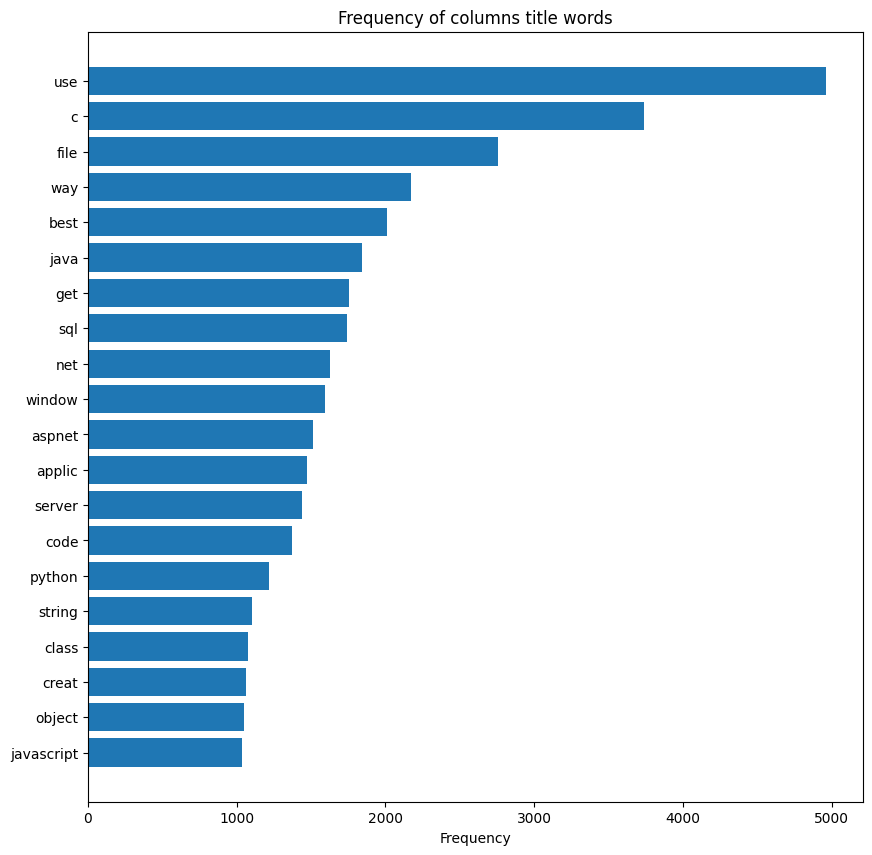

In [26]:
# calcul de la frequence de mot par colonne
def get_word_frequencies(column_data):
    all_words = [word for tokens in column_data for word in tokens]
    word_freq = Counter(all_words)
    return word_freq

# Calcul de la fréquence des mots pour la colonne 'Title'
title_word_freq = get_word_frequencies(df_final['Title'])

# 20 mots les plus fréquents
most_common_words = title_word_freq.most_common(20)
words, counts = zip(*most_common_words)

# Visualiser les fréquences des mots les plus courants
plt.figure(figsize=(10, 10))
plt.barh(range(len(words)), counts, align='center')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Frequency of columns title words')
plt.gca().invert_yaxis()  # invert_yaxis sert à avoir le mot le plus fréquent en haut
plt.show()

Au vue du graph les 5 mots les plus fréquent sur la colonne "Title" sont "use, c, file, way, best"

### Pour la colonne "Body"

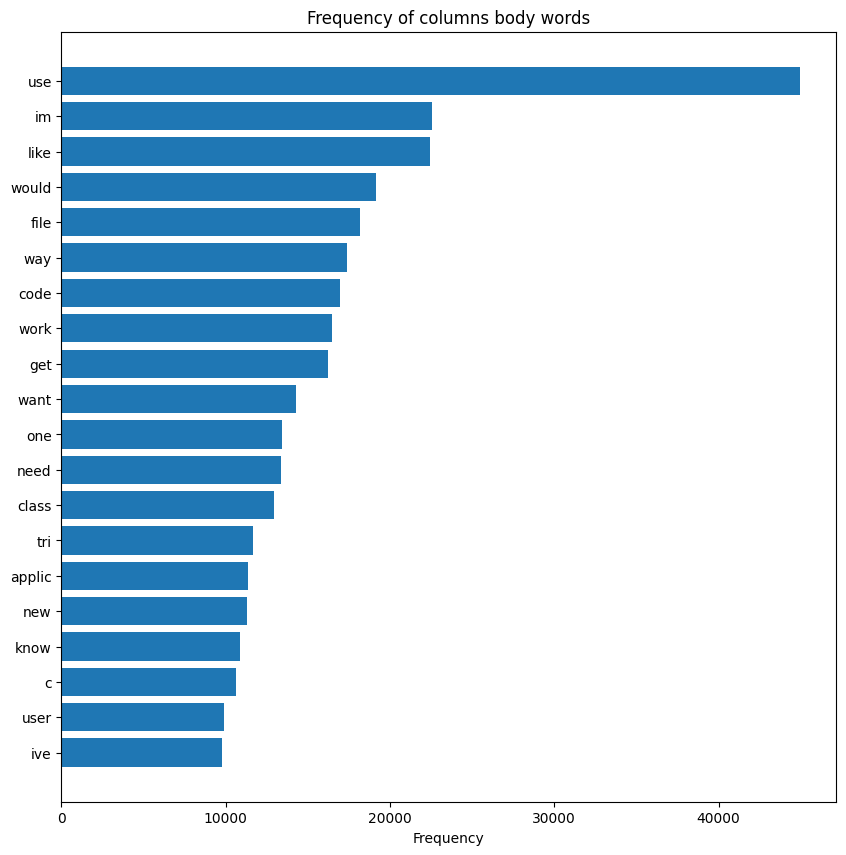

In [27]:

# calcul de la frequence des mots par colonne
def get_word_frequencies(column_data):
    all_words = [word for tokens in column_data for word in tokens]
    word_freq = Counter(all_words)
    return word_freq

# Calcul de la fréquence des mots pour la colonne 'Title'
title_word_freq = get_word_frequencies(df_final['Body'])

# 20 mots les plus fréquents
most_common_words = title_word_freq.most_common(20)
words, counts = zip(*most_common_words)

# Visualiser les fréquences des mots les plus courants
plt.figure(figsize=(10, 10))
plt.barh(range(len(words)), counts, align='center')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Frequency of columns body words')
plt.gca().invert_yaxis()
plt.show()

Au vue du graph les mots les plus frequent pour la colonne "Body" sont "use, im, like, would, file"

### Pour la colonne "new_tags"

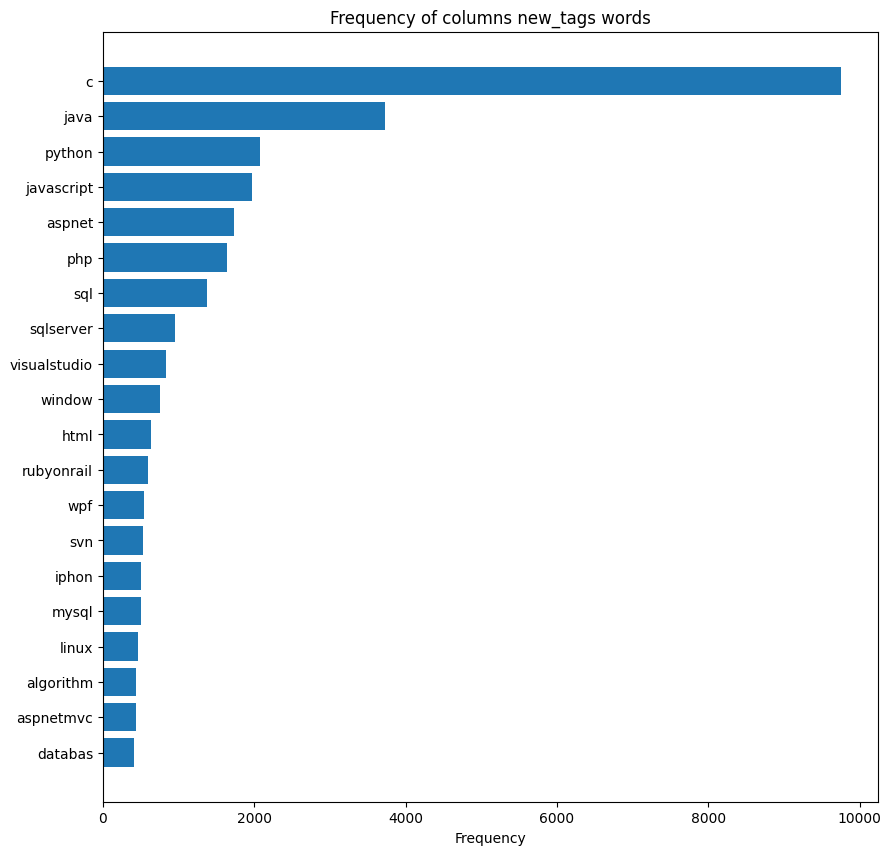

In [28]:

# calcul de la frequence des mot par colonne
def get_word_frequencies(column_data):
    all_words = [word for tokens in column_data for word in tokens]
    word_freq = Counter(all_words)
    return word_freq

# Calcul de la fréquence des mots pour la colonne 'new_tags'
title_word_freq = get_word_frequencies(df_final['new_tags'])

# 20 mots les plus fréquents
most_common_words = title_word_freq.most_common(20)
words, counts = zip(*most_common_words)

# Visualiser les fréquences des mots les plus courants
plt.figure(figsize=(10, 10))
plt.barh(range(len(words)), counts, align='center')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Frequency of columns new_tags words')
plt.gca().invert_yaxis()  
plt.show()

Au vue du graph les 5 tags les plus utiliser pour la colonne "new_tags" sont "c, java, python, javascript, aspnet"

### Analyse des mots les plus frequents par nuage de mot par colonne

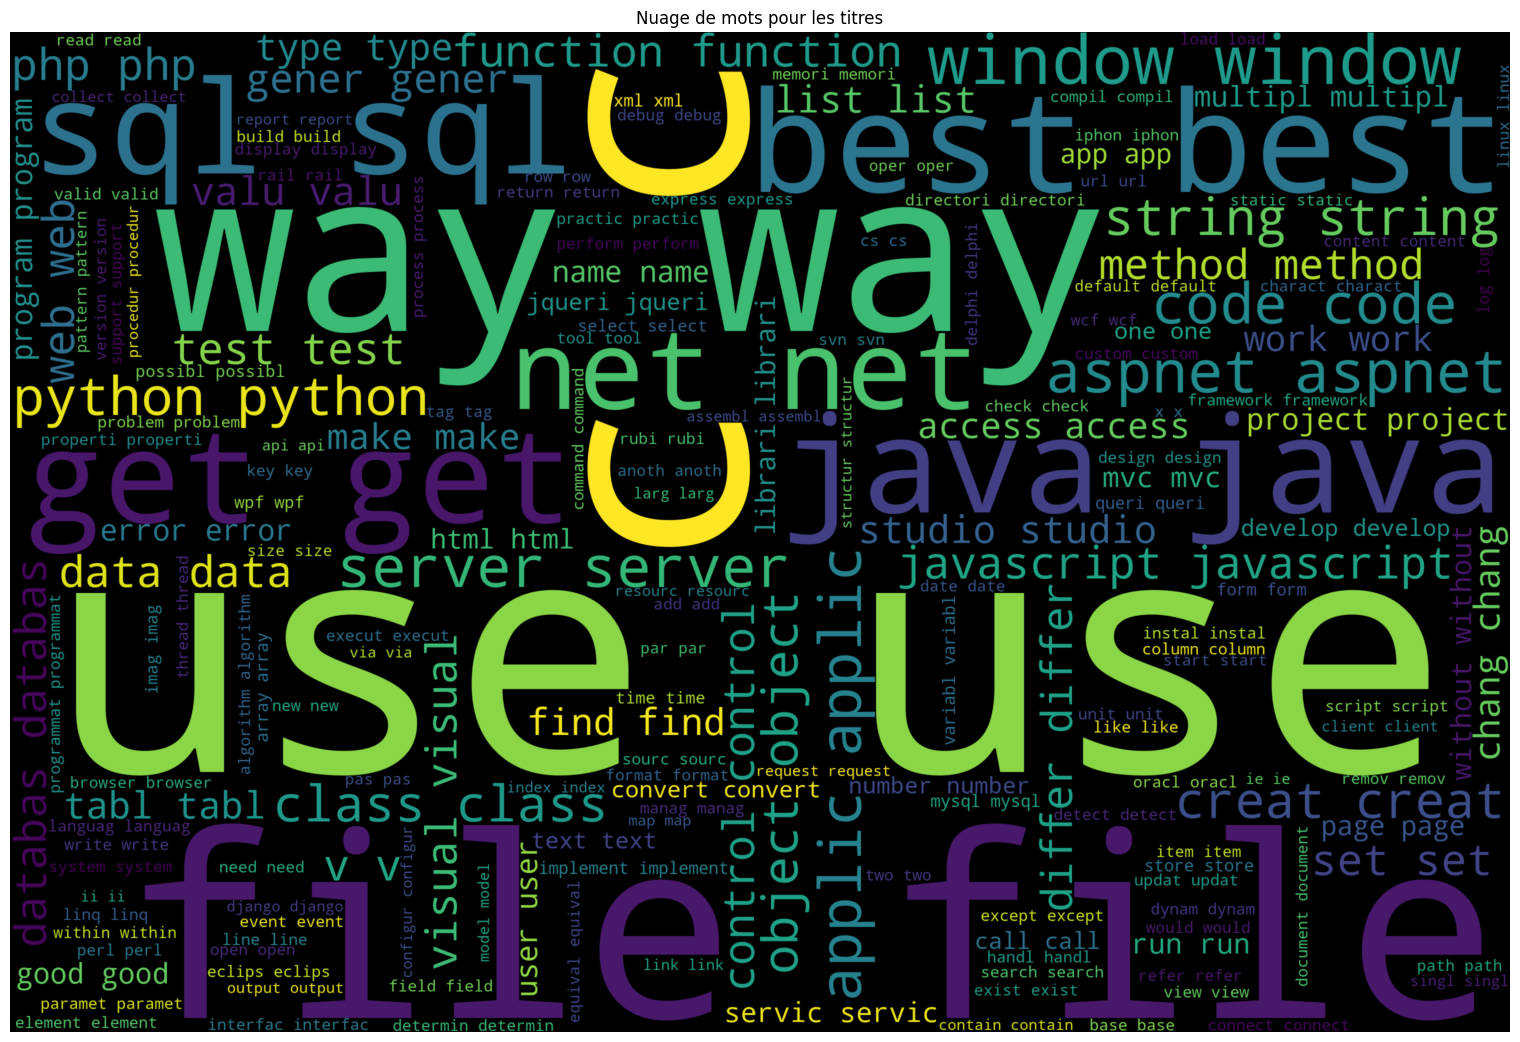

In [29]:
# création de nuage de mots pour la colonne title
title_word_freq = get_word_frequencies(preprocessed_df['Title'])

# Convertir les fréquences de mots en une seule chaîne de texte
text = ' '.join([word for word, freq in title_word_freq.items() for _ in range(freq)])

# Créer et afficher le nuage de mots
wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='black',
    stopwords=set(stopwords.words('english'))
).generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Nuage de mots pour les titres')
plt.show()

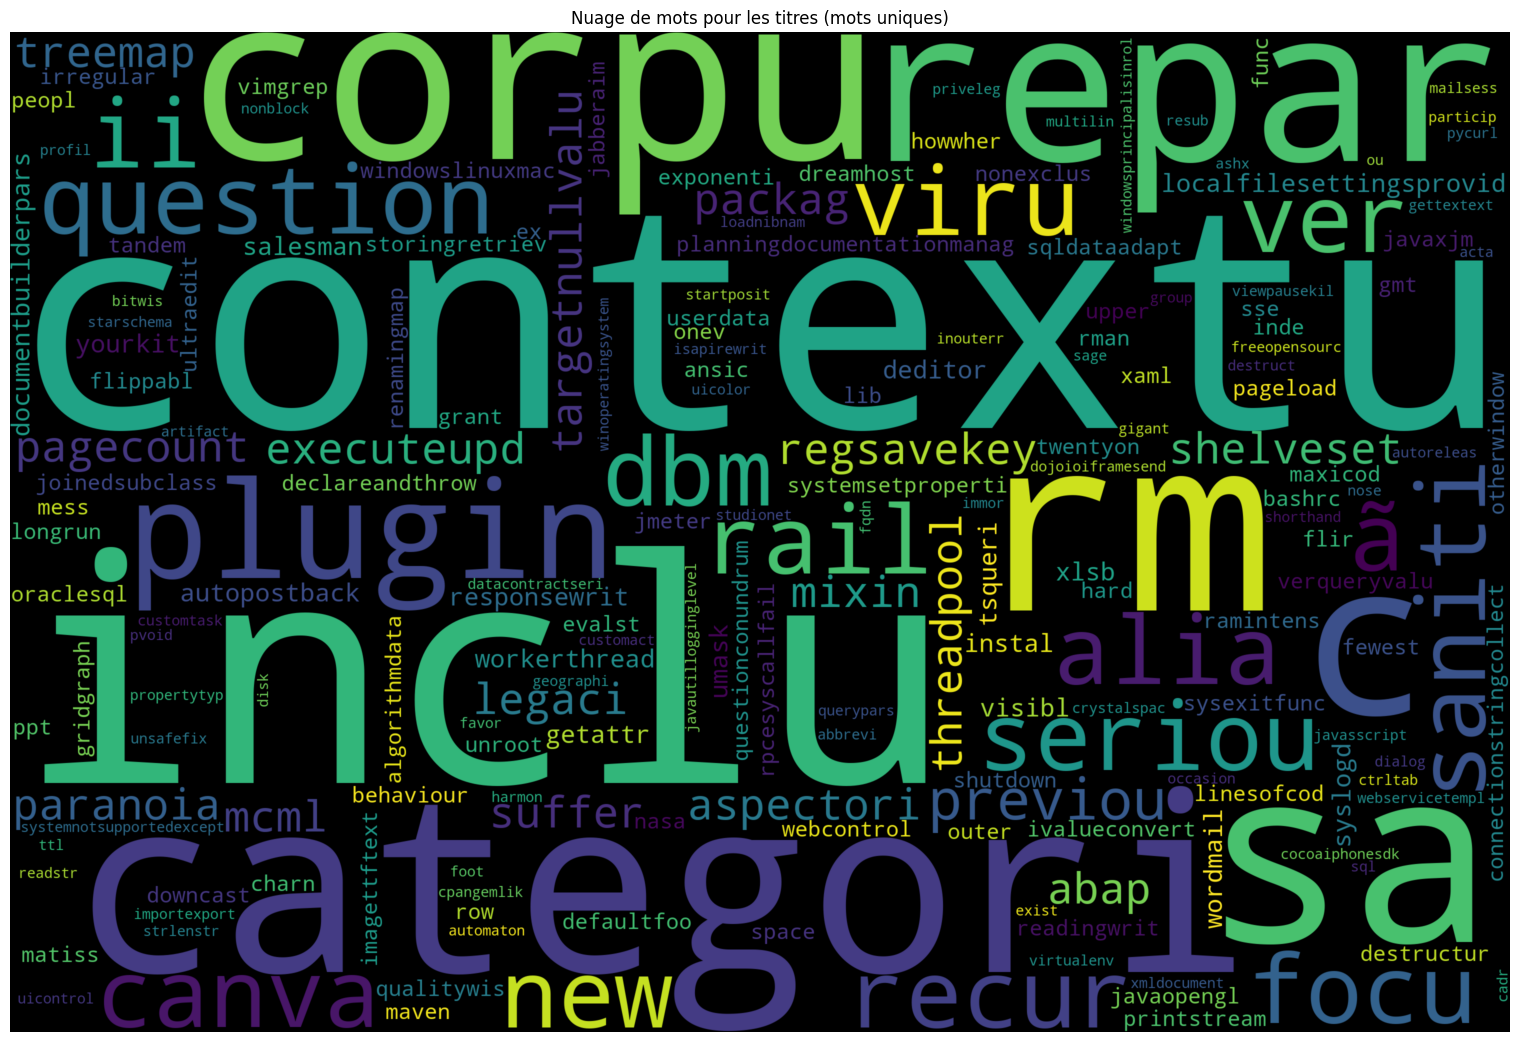

In [30]:
# création de nuage de mots pour la colonne Title
titles = preprocessed_df['Title']

# Liste de mots uniques
unique_words = set()
stop_words = set(stopwords.words('english'))
for title in titles:
    unique_words.update(word.lower() for word in title if word.lower() not in stop_words)

# chaîne de texte à partir des mots uniques
unique_words_text = ' '.join(unique_words)

# nuage de mots
wordcloud = WordCloud(
   width=3000,
   height=2000,
   background_color='black'
).generate(unique_words_text)

# Affiche le nuage de mots
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Nuage de mots pour les titres (mots uniques)')
plt.show()
 

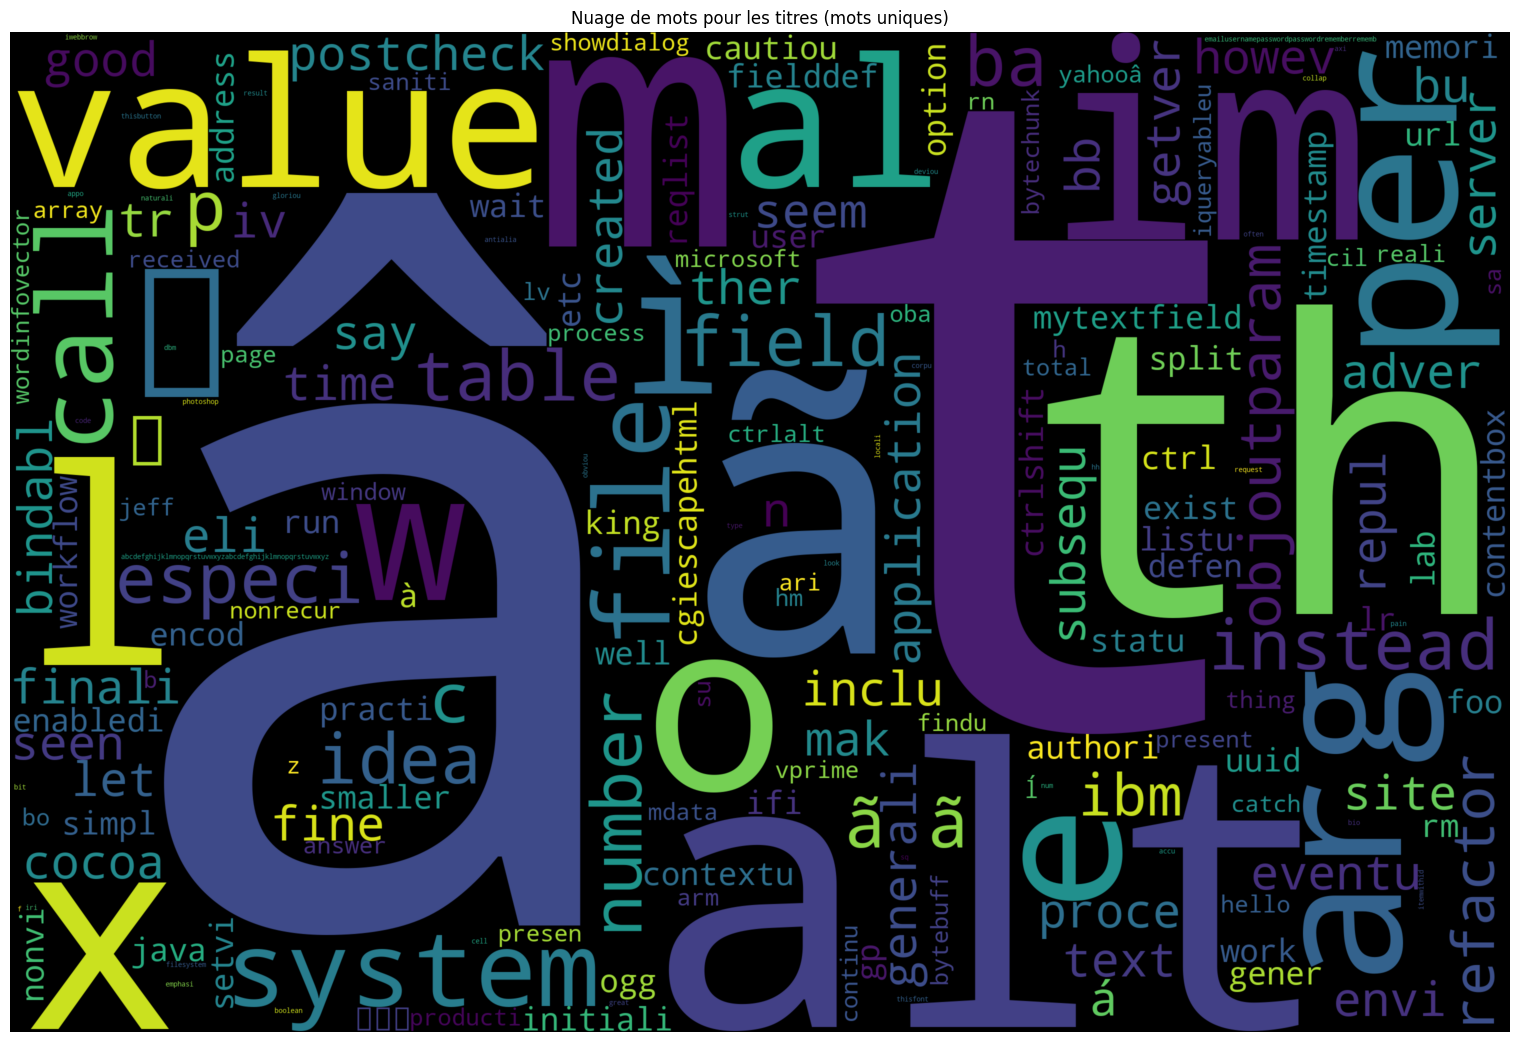

In [31]:
# création de nuage de mots pour la colonne Body
bodys = preprocessed_df['Body']

# Liste de mots uniques
unique_words = set()
stop_words = set(stopwords.words('english'))
for body in bodys:
    unique_words.update(word.lower() for word in body if word.lower() not in stop_words)

# chaîne de texte à partir des mots uniques
unique_words_text = ' '.join(unique_words)

# nuage de mots
wordcloud = WordCloud(
   width=3000,
   height=2000,
   background_color='black'
).generate(unique_words_text)

# Affiche le nuage de mots
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Nuage de mots pour les titres (mots uniques)')
plt.show()

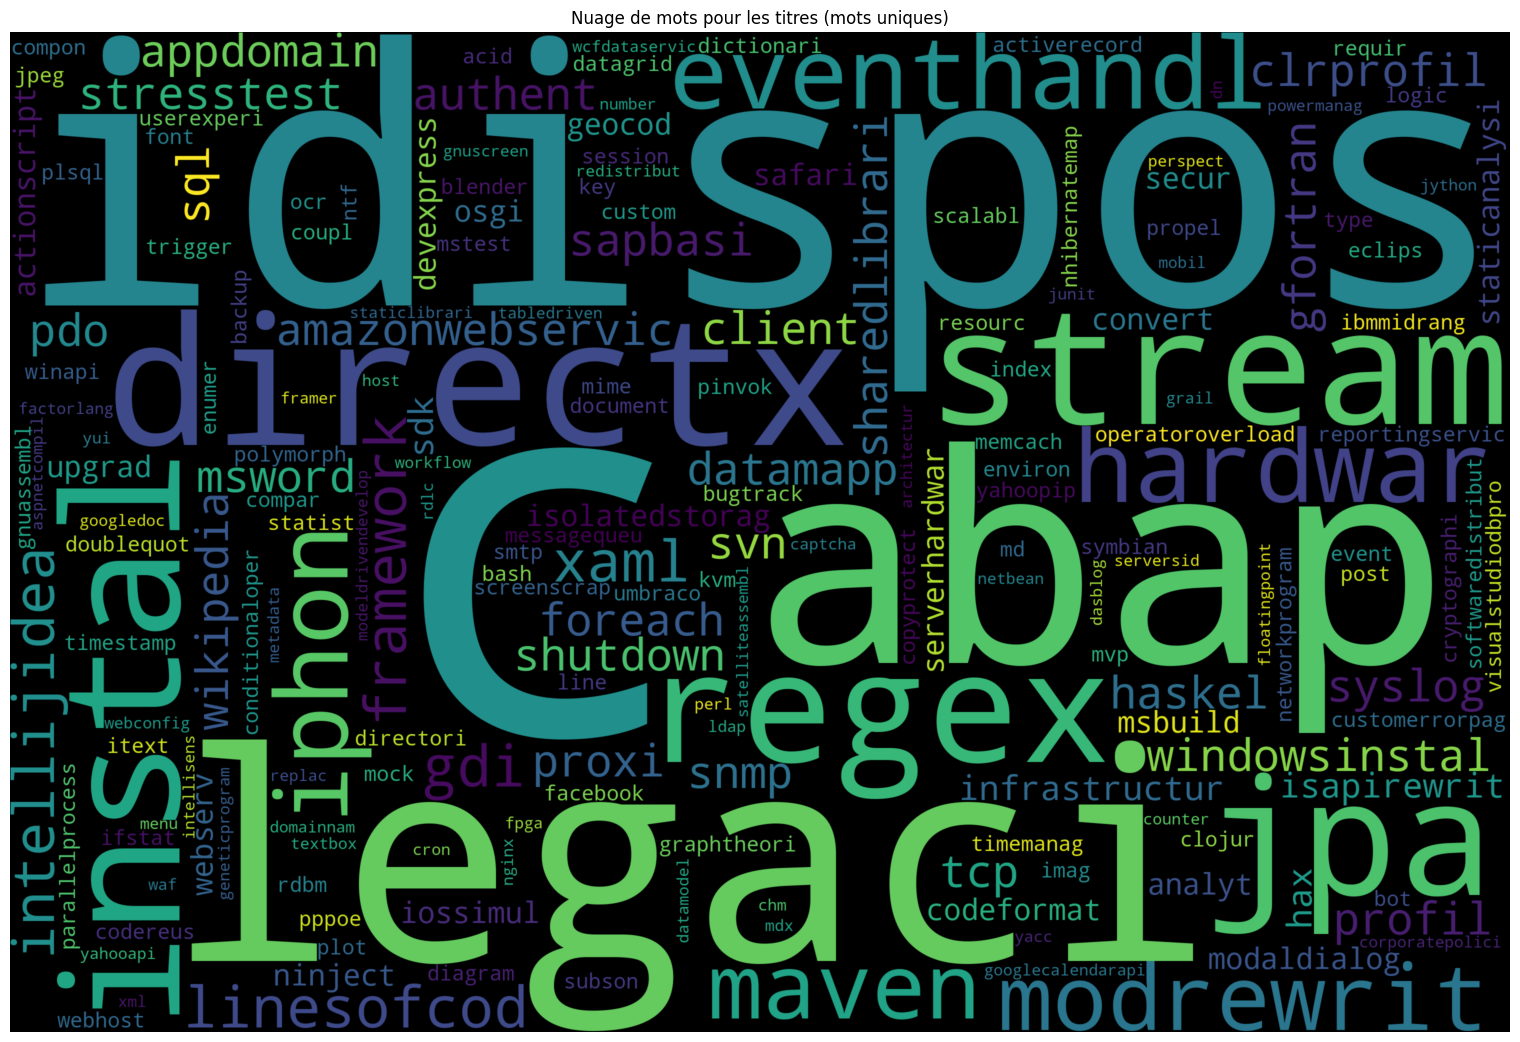

In [32]:
# création de nuage de mots pour la colonne new_tags

tags = preprocessed_df['new_tags']

# Liste de mots uniques
unique_words = set()
stop_words = set(stopwords.words('english'))
for tag in tags:
    unique_words.update(word.lower() for word in tag if word.lower() not in stop_words)

# une chaîne de texte à partir des mots uniques
unique_words_text = ' '.join(unique_words)

# nuage de mots
wordcloud = WordCloud(
   width=3000,
   height=2000,
   background_color='black'
).generate(unique_words_text)

# Affiche le nuage de mots
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Nuage de mots pour les titres (mots uniques)')
plt.show()

# Analyse Multivarié

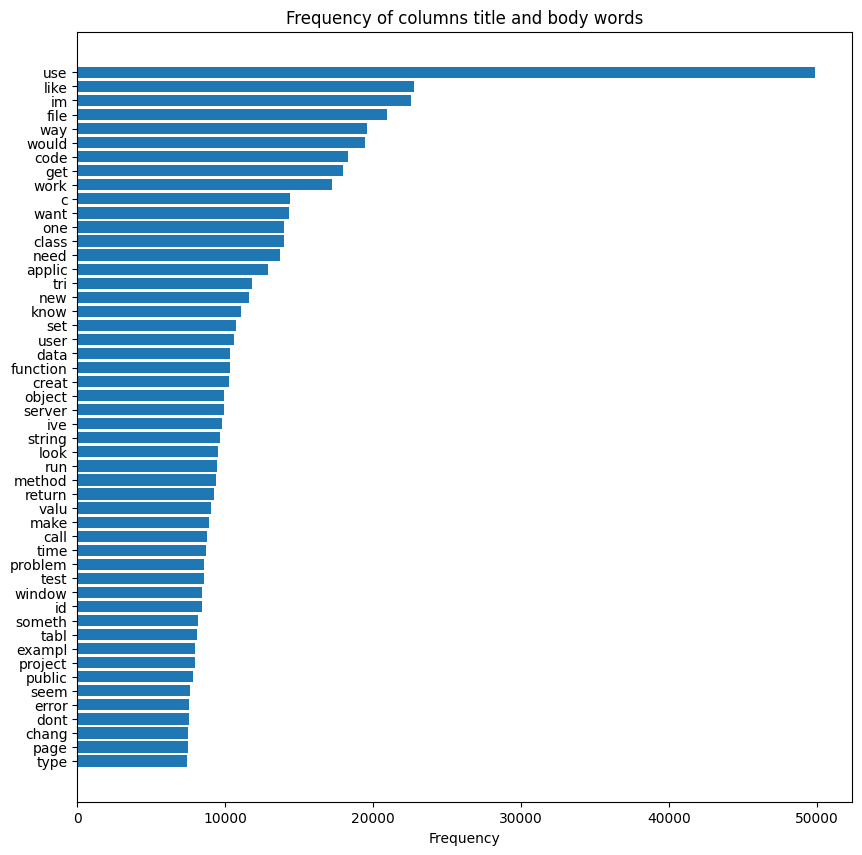

In [33]:
# Calcule les fréquences des mots pour les colonnes Title et body
def get_word_frequencies(column_data):
    all_words = [word for tokens in column_data for word in tokens]
    word_freq = Counter(all_words)
    return word_freq

title_word_freq = get_word_frequencies(df_final['Title'])
body_word_freq = get_word_frequencies(df_final['Body'])

# Combine les mots des deux colonnes
combined_word_freq = title_word_freq + body_word_freq

# 50 mots les plus fréquents
most_common_words = combined_word_freq.most_common(50)
words, counts = zip(*most_common_words)

# Visualiser les fréquences des mots les plus courants
plt.figure(figsize=(10, 10))
plt.barh(range(len(words)), counts, align='center')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Frequency of columns title and body words')
plt.gca().invert_yaxis() 
plt.show()

In [34]:
# Garder uniquement les 15 tags les plus fréquents
top_15_tags = df_final['new_tags'].explode().value_counts().head(15).index.tolist()

# df_filtered garde uniquement les lignes avec les 15 tags les plus frequents
df_filtered = df_final[df_final['new_tags'].apply(lambda tags: any(tag in top_15_tags for tag in tags))] 

In [35]:
# verification du df_filtered
df_filtered.head(5)

Title  \
0                         [convert, decim, doubl, c]   
1  [width, collaps, percentag, width, child, elem...   
2  [calcul, someon, age, base, datetim, type, bir...   
3                             [calcul, rel, time, c]   
4                          [determin, user, timezon]   

                                                Body new_tags  
0  [want, assign, decim, variabl, tran, doubl, va...      [c]  
1  [absolut, posit, div, contain, sever, child, o...   [html]  
2  [given, datetim, repres, person, birthday, cal...      [c]  
3  [given, specif, datetim, valu, display, rel, t...      [c]  
4  [standard, way, web, server, abl, determin, us...   [html]

In [36]:
# Transformer les listes de tokens en chaînes de caractères
df_filtered.loc[:,'Title'] = df_filtered['Title'].apply(lambda tokens: ' '.join(tokens))
df_filtered.loc[:,'Body'] = df_filtered['Body'].apply(lambda tokens: ' '.join(tokens))
df_filtered.loc[:,'new_tags'] = df_filtered['new_tags'].apply(lambda tokens: ' '.join(tokens))

In [37]:
df_filtered.head(5)

Title  \
0                              convert decim doubl c   
1  width collaps percentag width child element ab...   
2       calcul someon age base datetim type birthday   
3                                  calcul rel time c   
4                              determin user timezon   

                                                Body new_tags  
0  want assign decim variabl tran doubl variabl t...        c  
1  absolut posit div contain sever child one rel ...     html  
2  given datetim repres person birthday calcul ag...        c  
3  given specif datetim valu display rel time lik...        c  
4  standard way web server abl determin user time...     html

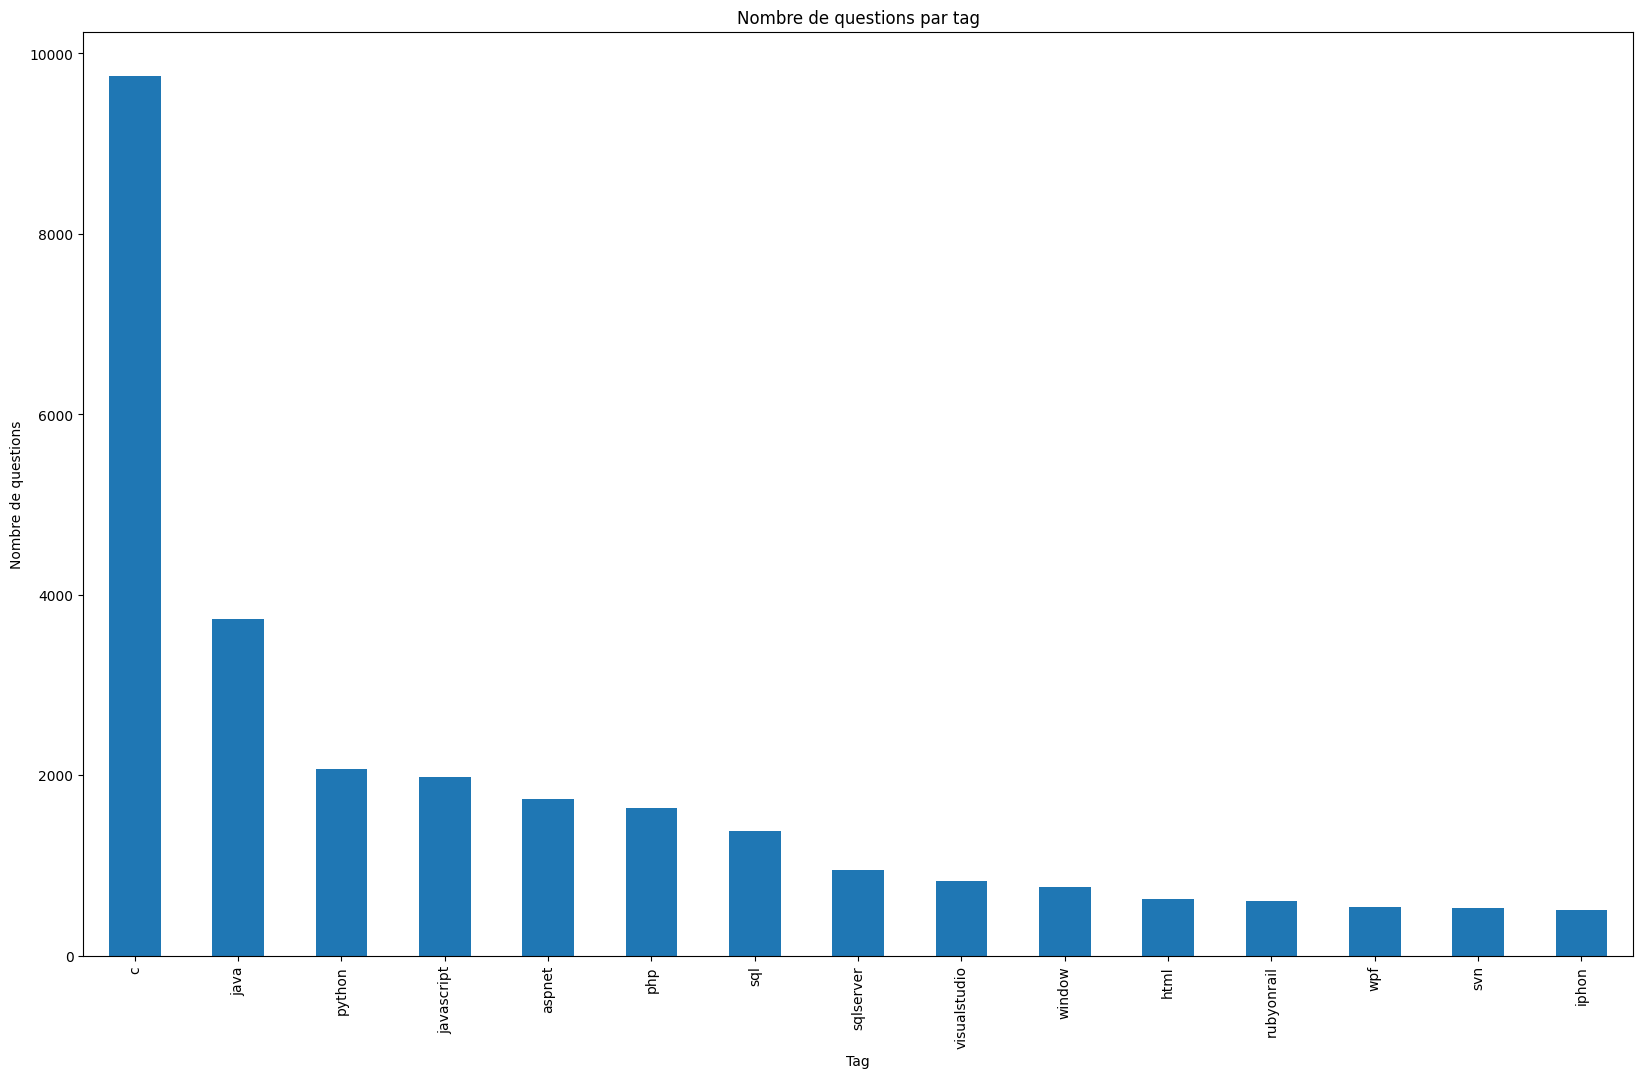

In [38]:
# Compter le nombre de questions par tag
tag_counts = df_filtered['new_tags'].value_counts()

# Créer un graphique en barres
plt.figure(figsize=(20, 12))
tag_counts.plot(kind='bar')
plt.title('Nombre de questions par tag')
plt.xlabel('Tag')
plt.ylabel('Nombre de questions')
plt.show()

# Label encoder

Utilisation d'un label encoder afin d'encoder la colonne "new_tags"

In [39]:
# Initialiser LabelEncoder
le = LabelEncoder()

# Encode les tags
df_filtered.loc[:, 'encoded_tags'] = le.fit_transform(df_filtered['new_tags'])

C:\Users\bleye\AppData\Local\Temp\ipykernel_11508\3131191838.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'encoded_tags'] = le.fit_transform(df_filtered['new_tags'])


label encodeur contrairement a one hot encodeur assigne une valeur numerique unique a chaque etiquette 

In [40]:
# Vérification que le nombre du nombre de ligne du df 
len(df_filtered)   

27632

In [41]:
df_filtered.head(5)

Title  \
0                              convert decim doubl c   
1  width collaps percentag width child element ab...   
2       calcul someon age base datetim type birthday   
3                                  calcul rel time c   
4                              determin user timezon   

                                                Body new_tags  encoded_tags  
0  want assign decim variabl tran doubl variabl t...        c             1  
1  absolut posit div contain sever child one rel ...     html             2  
2  given datetim repres person birthday calcul ag...        c             1  
3  given specif datetim valu display rel time lik...        c             1  
4  standard way web server abl determin user time...     html             2

vérification que l'encodage à bien été effectué

In [42]:
# regroupement des deux colonne body and title pour former la colonne texte
df_filtered['text'] = df_filtered['Title'] + ' ' + df_filtered['Body']

C:\Users\bleye\AppData\Local\Temp\ipykernel_11508\369203422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['text'] = df_filtered['Title'] + ' ' + df_filtered['Body']


In [43]:
# Diviser les données en ensembles en train and test
X_train, X_test, y_train, y_test = train_test_split(df_filtered[['text']], df_filtered['encoded_tags'], test_size=0.2, random_state=42)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22105, 1)
(5527, 1)
(22105,)
(5527,)


# Bag-of-word -- tf-idf

Création d'un bag of word

In [45]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialisation des vectorizers
vectorizer = TfidfVectorizer(max_features=30000, max_df=0.95, min_df=2)

 min_df précise que je souhaite que le mot soit présent minimum 2 fois pour être pris en compte.  
 max_df 0.95 signifie que je ne prend pas un mot si il est présent à plus de 95% car, un mot trop présent ne donne pas d'information intéressantes.

# Réseau de neurone

## LDA : Latent Derelicht Analysis

Modèle de reseau de neurone non supervisée

In [53]:
from sklearn.decomposition import LatentDirichletAllocation
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


In [54]:
df_filtered.head(5)

Title  \
0                              convert decim doubl c   
1  width collaps percentag width child element ab...   
2       calcul someon age base datetim type birthday   
3                                  calcul rel time c   
4                              determin user timezon   

                                                Body new_tags  encoded_tags  \
0  want assign decim variabl tran doubl variabl t...        c             1   
1  absolut posit div contain sever child one rel ...     html             2   
2  given datetim repres person birthday calcul ag...        c             1   
3  given specif datetim valu display rel time lik...        c             1   
4  standard way web server abl determin user time...     html             2   

                                                text  
0  convert decim doubl c want assign decim variab...  
1  width collaps percentag width child element ab...  
2  calcul someon age base datetim type birthday g...  
3  calcul rel time c given specif datetim valu di...  
4  determin user timezon standard way web server ...

In [55]:
# Initialiser les vectorizers
vectorizer = TfidfVectorizer(max_features=30000, max_df=0.95, min_df=2)

In [56]:
# # Chargement de l'encodeur de phrase USE
# use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # use n'est pas compable avec le modele LDA car certain vecteur sont negatif

In [57]:
# Combinaison des vecteurs titre et corps
X_text = vectorizer.fit_transform(df_filtered['text'])
y = (df_filtered['encoded_tags'])

In [58]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42)

In [59]:
# Nombre de topics
n_topics = 15

# initialisation du modèle LDA
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# Entraîner le modèle LDA
lda.fit(X_text)

LatentDirichletAllocation(n_components=15, random_state=42)

In [60]:
# Prédire les topics 
topic_distribution = lda.transform(X_train)
predicted_topics = np.argmax(topic_distribution, axis=1)

In [61]:
# Afficher les composants principaux
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [62]:
# Nombre de mots les plus importants à afficher par topic
n_top_words = 10

In [63]:
# Récupérer les noms des features
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, n_top_words)

Topic 0:
tooltip ioc pdo classa slider music classb clojur jtabl speech
Topic 1:
file use applic window im project code would way like
Topic 2:
utf unicod encod char int includ cout convert unsign endl
Topic 3:
richtextbox clipboard selenium matlab xmlrpc strut eventlog windsor beautifi tunnel
Topic 4:
svg hashtabl ifoo jcombobox testclass bid join ibati tableid mytyp
Topic 5:
tray ipv inputstream outputstream listint acceler systemoutprintln unlock basepag se
Topic 6:
sql tabl queri databas select use column server date way
Topic 7:
cultur myvar ipc invers someobject columndefinit sizeof stderr watermark uml
Topic 8:
svn flash branch vim git rss movi feed macro highlight
Topic 9:
array string byte int char convert charact valu way use
Topic 10:
cooki session tabl login key sql user column server insert
Topic 11:
mime greasemonkey webcam capit printr decor probe myproperti defaultvalu defaultt
Topic 12:
page control html form div button event javascript jqueri text
Topic 13:
class publ

In [64]:
# Fonction pour afficher les poids des termes les plus importants
def plot_top_term_weights(voc, weights, topic_idx, top, model_name):

    # get the top terms and their weights
    top_indices = np.argsort(weights[topic_idx, :])[::-1]
    top_terms = []
    top_weights = []
    for term_idx in top_indices[0:top]:
        top_terms.append(voc[term_idx])
        top_weights.append(weights[topic_idx, term_idx])
    # reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    f, ax = plt.subplots(figsize=(10, 5))
    ypos = np.arange(top)
    ax.barh(ypos, top_weights, align="center", color="#19baff", tick_label=top_terms)
    plt.xlabel("Term Weight", fontsize=14)
    plt.title(f"Top {top} terms in the Topic {topic_idx+1:02d} ({model_name})")
    f.tight_layout()
    plt.show()

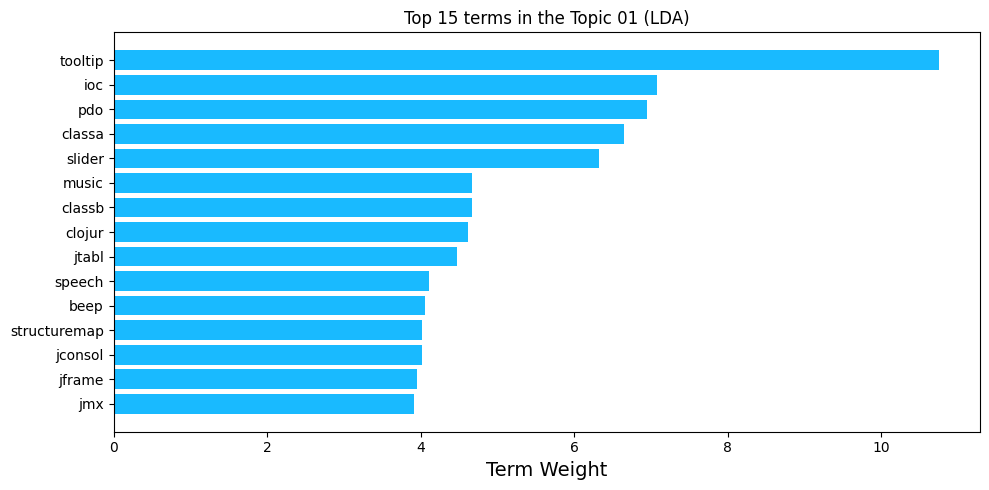

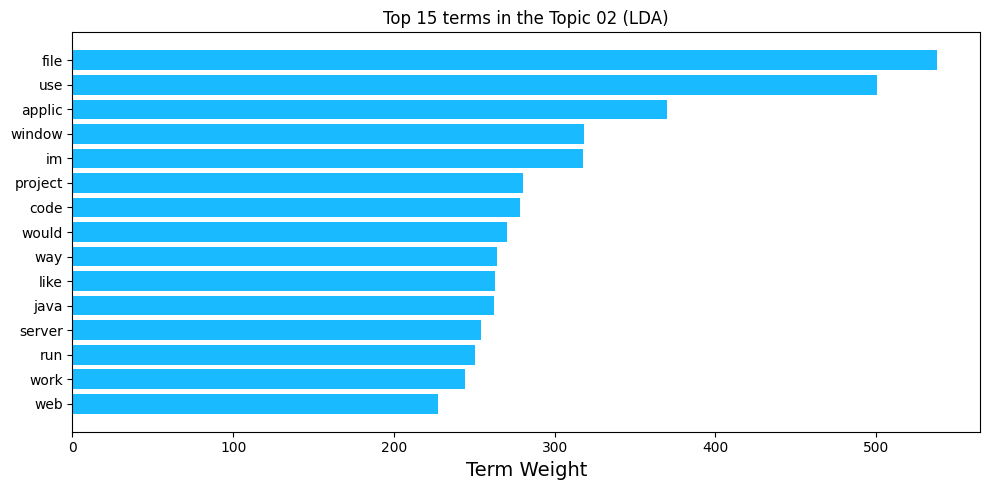

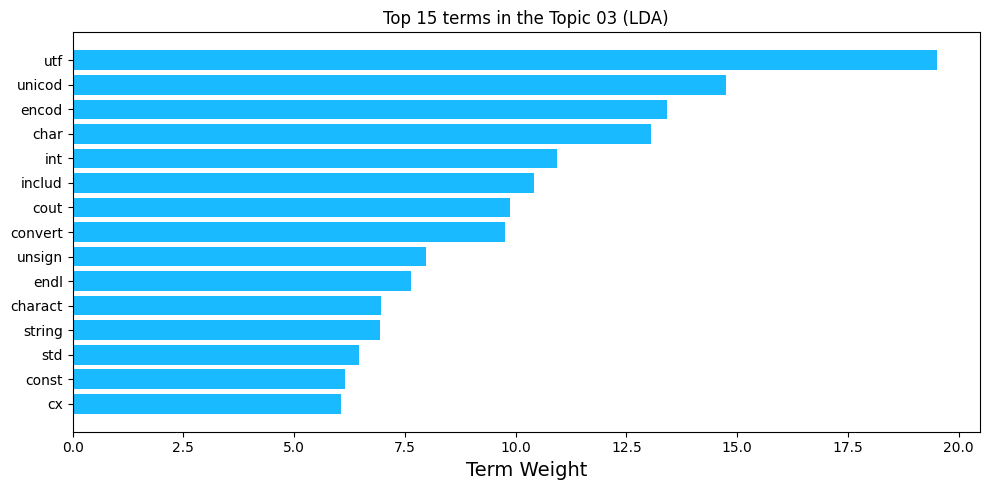

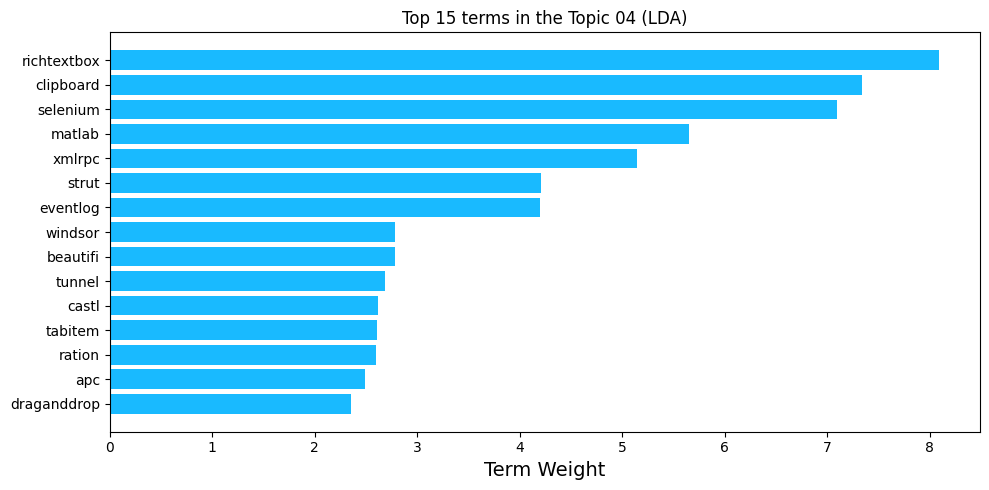

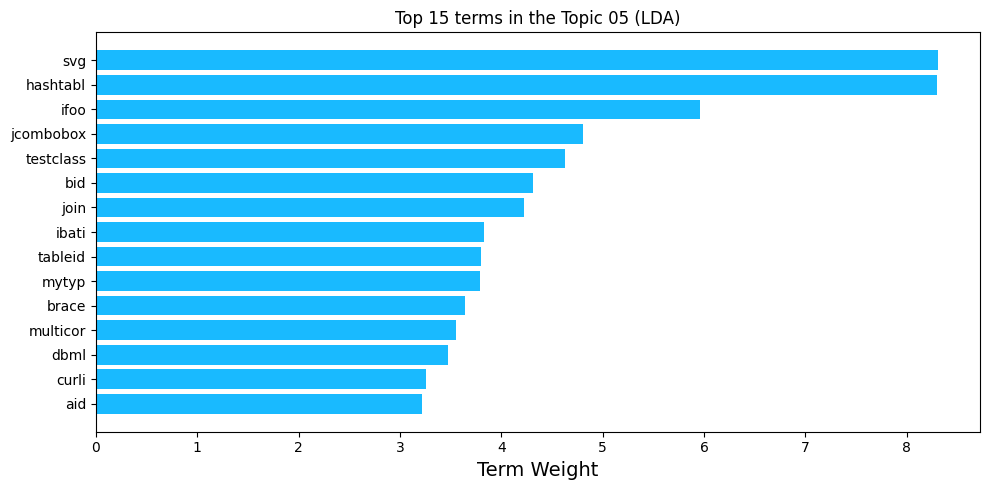

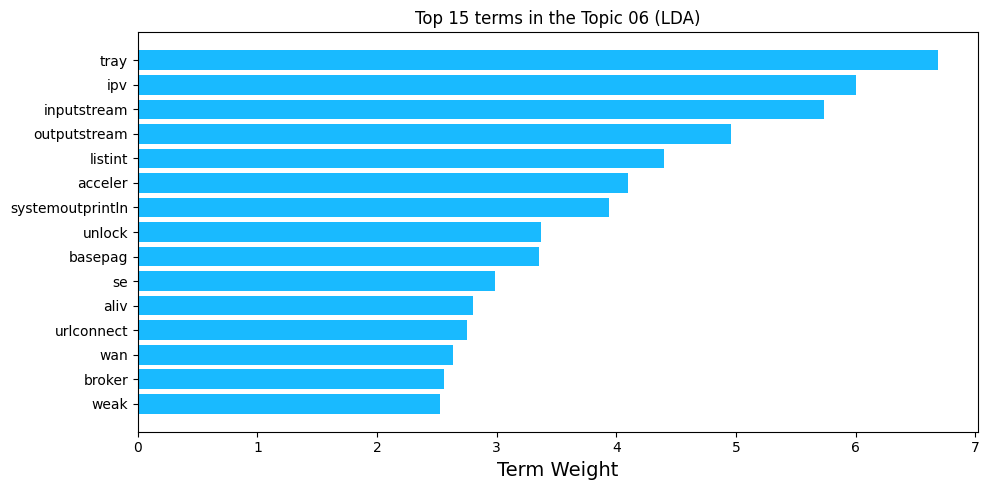

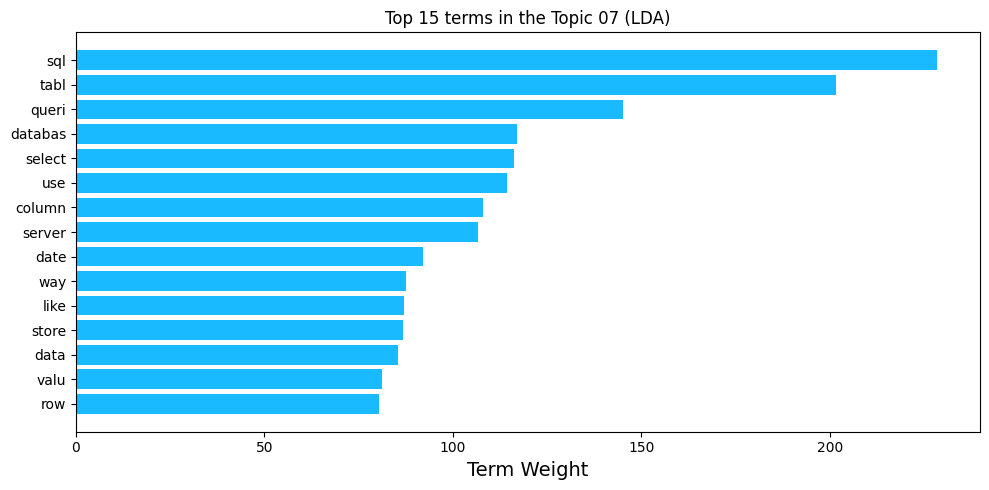

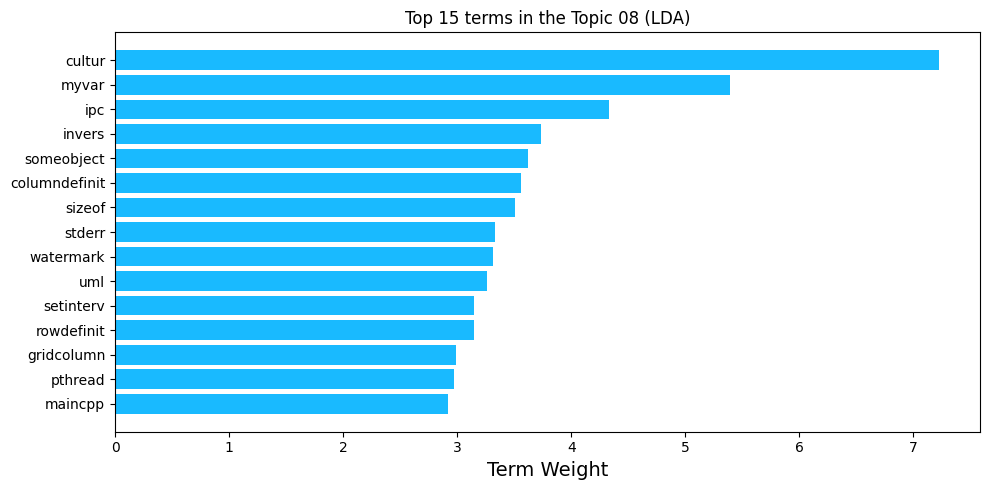

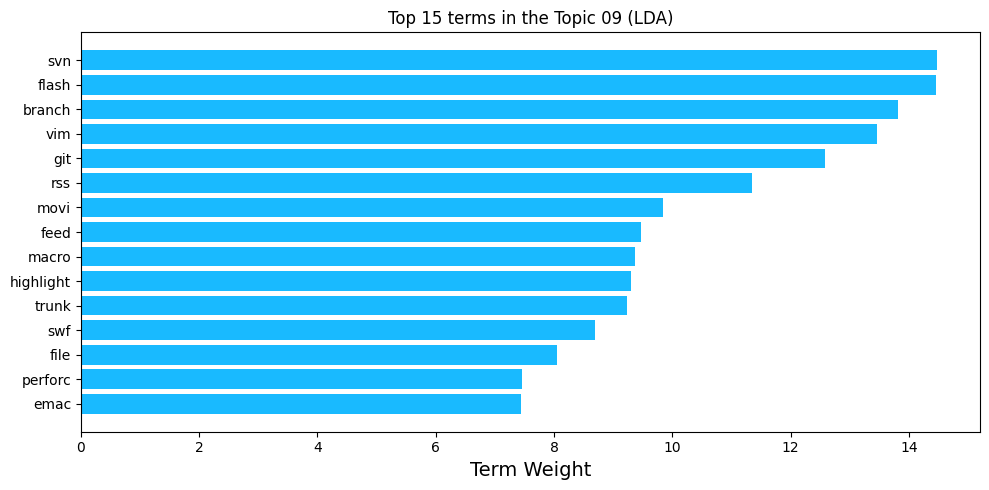

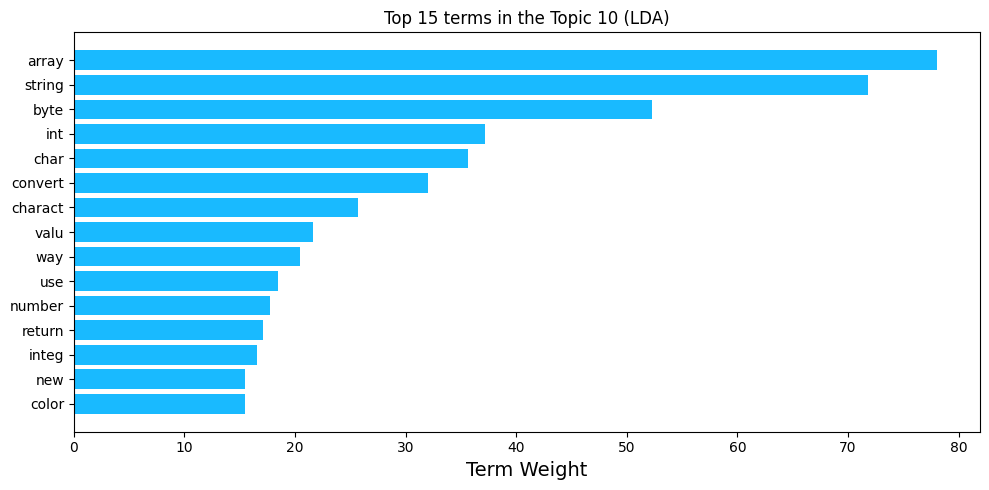

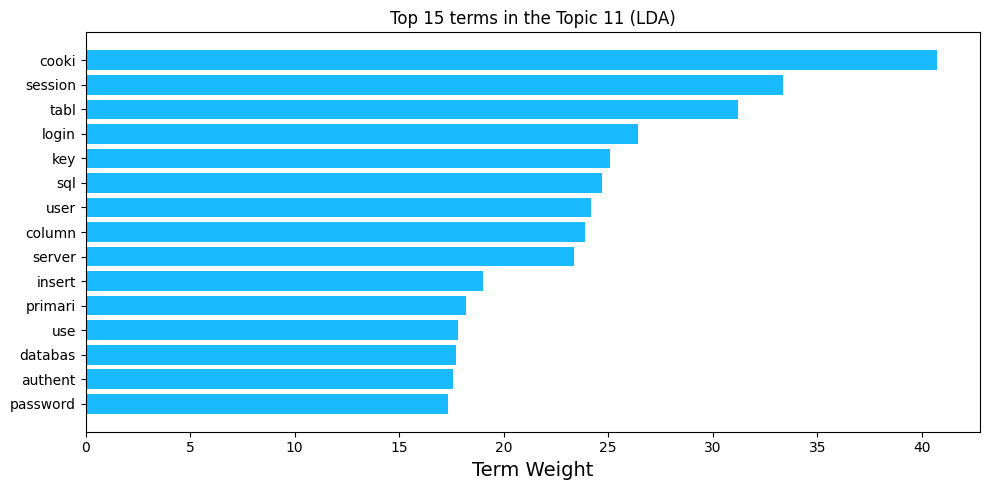

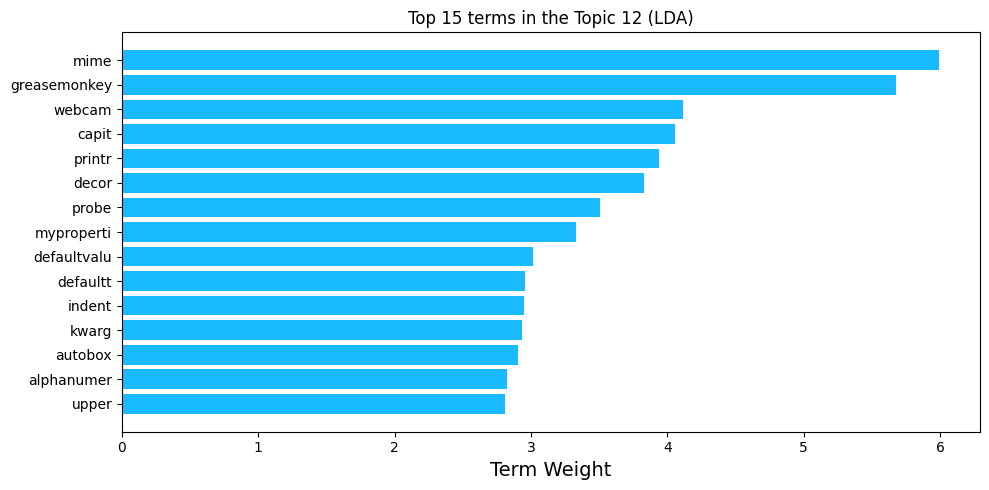

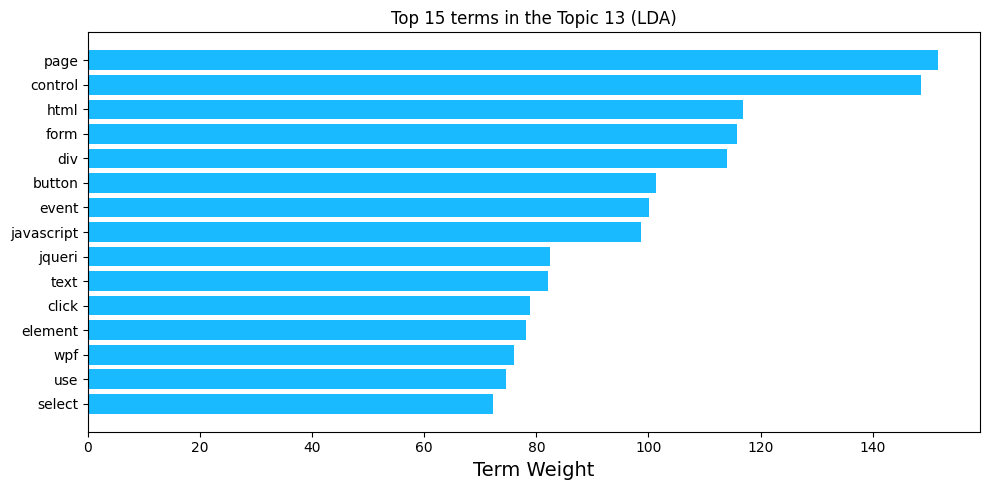

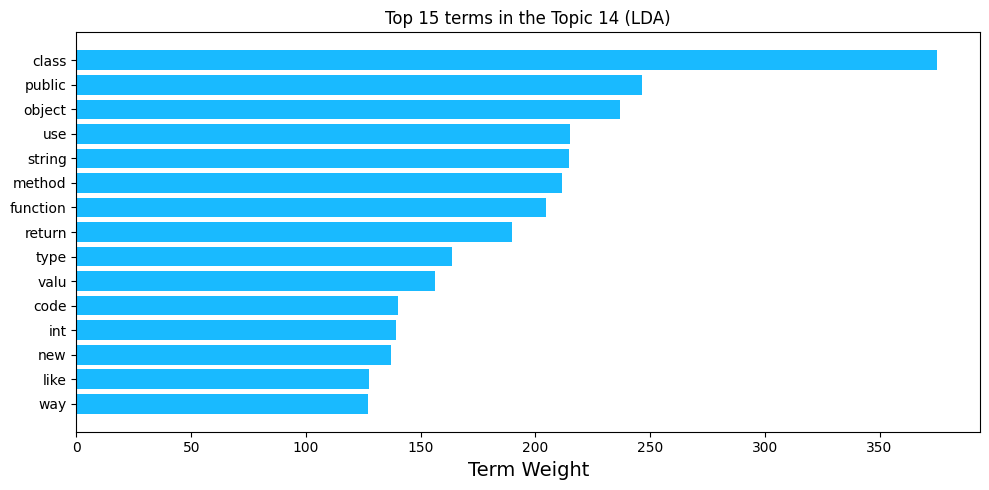

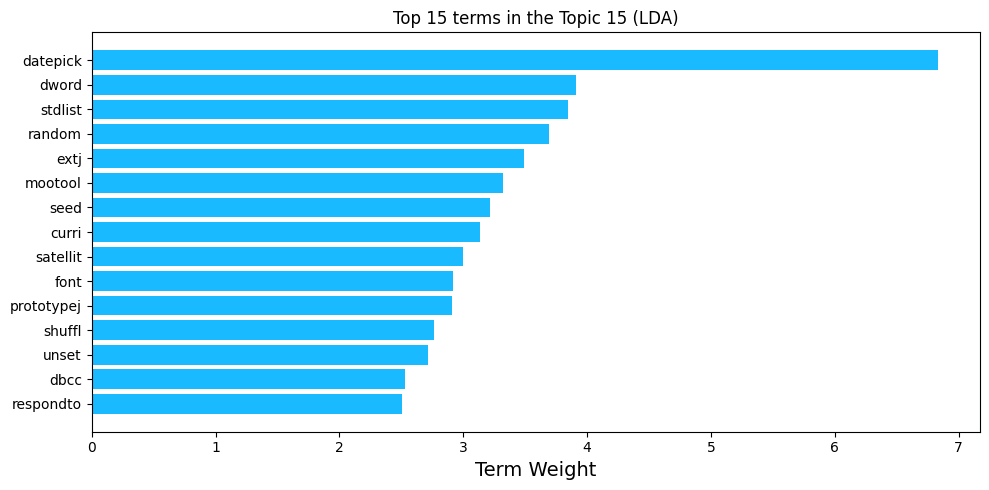

In [65]:
# Afficher les poids des termes pour chaque topic
for i in range(n_topics):
    plot_top_term_weights(tf_feature_names, lda.components_, i, 15, 'LDA')

## Réseau de neurone avec keras

pour rappel les labels (colonne encoded_tags) ont déjà été encoder précedement 

In [72]:
import tensorflow_hub as hub
from sklearn.metrics import adjusted_rand_score
# # from sentence_transformers import SentenceTransformer
# from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import layers
import tensorflow as tf

In [73]:
df_filtered.head(5)

Title  \
0                              convert decim doubl c   
1  width collaps percentag width child element ab...   
2       calcul someon age base datetim type birthday   
3                                  calcul rel time c   
4                              determin user timezon   

                                                Body new_tags  encoded_tags  \
0  want assign decim variabl tran doubl variabl t...        c             1   
1  absolut posit div contain sever child one rel ...     html             2   
2  given datetim repres person birthday calcul ag...        c             1   
3  given specif datetim valu display rel time lik...        c             1   
4  standard way web server abl determin user time...     html             2   

                                                text  
0  convert decim doubl c want assign decim variab...  
1  width collaps percentag width child element ab...  
2  calcul someon age base datetim type birthday g...  
3  calcul rel time c given specif datetim valu di...  
4  determin user timezon standard way web server ...

In [74]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_filtered['text'], df_filtered['encoded_tags'], test_size=0.3, random_state=42)

In [76]:
# Chargement de l'encoder use
import os
# os.environ['TFHUB_CACHE_DIR'] = 'C:\Users\bleye\Desktop'

use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [77]:
# Fonction pour encoder les textes
def embed_text(text):
    return use(text)

In [78]:
# Encodage des textes d'entraînement et de test
X_train_embeddings = embed_text(X_train.tolist()).numpy()
X_test_embeddings = embed_text(X_test.tolist()).numpy()

In [79]:
# Construction du modèle de réseau de neurones

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512,)),  # USE produit des vecteurs de dimension 512
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax') 
])

In [80]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,159 (649.06 KB)

 Trainable params: 166,159 (649.06 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
batch_size=32
epochs = 8

In [83]:
# ajout d'un early-stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [85]:
# Entraînement du modèle
history = model.fit(X_train_embeddings, y_train, epochs=5, validation_split=0.2, batch_size=32)

Epoch 1/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5367 - loss: 1.5455 - val_accuracy: 0.7661 - val_loss: 0.6956
Epoch 2/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7715 - loss: 0.6953 - val_accuracy: 0.7811 - val_loss: 0.6640
Epoch 3/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7831 - loss: 0.6483 - val_accuracy: 0.7782 - val_loss: 0.6536
Epoch 4/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8005 - loss: 0.5914 - val_accuracy: 0.7852 - val_loss: 0.6440
Epoch 5/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8111 - loss: 0.5582 - val_accuracy: 0.7811 - val_loss: 0.6423


In [86]:
# Évaluation du modèle 
loss, accuracy = model.evaluate(X_test_embeddings, y_test)
print(f'Accuracy: {accuracy:.4f}')

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.7890 - loss: 0.6206
Accuracy: 0.7872


https://medium.com/@erika.dauria/accuracy-recall-precision-80a5b6cbd28d

In [87]:
# Prédictions
y_pred = model.predict(X_test_embeddings)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [88]:
# Calcul de l'ARI
ari_score = adjusted_rand_score(y_test, y_pred_labels)
print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')

Adjusted Rand Index (ARI): 0.6110


# appliquer un grid search pour ameliorer le modele 

https://keras.io/keras_tuner/

In [ ]:
import tensorflow as tf

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(512,)))  

    # Hyperparamètres pour la première couche dense
    model.add(tf.keras.layers.Dense(units=hp.Int('units_1', min_value=128, max_value=512, step=64),
                                    activation=hp.Choice('activation_1', values=['relu', 'tanh'])))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))

    # Hyperparamètres pour la deuxième couche dense
    model.add(tf.keras.layers.Dense(units=hp.Int('units_2', min_value=64, max_value=256, step=64),
                                    activation=hp.Choice('activation_2', values=['relu', 'tanh'])))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(len(le.classes_), activation='softmax'))

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialiser le tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Nombre maximum d'essais
    executions_per_trial=3,  # Exécutions par essai 

)


In [ ]:
# Sommaire de l'espace de recherche
tuner.search_space_summary()

# Recherche des hyperparamètres
tuner.search(X_train_embeddings, y_train,
             epochs=20,
             validation_split=0.2,
             batch_size=32,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Récupérer les meilleurs hyperparamètre
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
La recherche des hyperparamètres est terminée. Voici les meilleurs hyperparamètres trouvés:
- Unités de la première couche dense: {best_hps.get('units_1')}
- Activation de la première couche dense: {best_hps.get('activation_1')}
- Taux de dropout de la première couche dense: {best_hps.get('dropout_1')}
- Unités de la deuxième couche dense: {best_hps.get('units_2')}
- Activation de la deuxième couche dense: {best_hps.get('activation_2')}
- Taux de dropout de la deuxième couche dense: {best_hps.get('dropout_2')}
- Optimiseur: {best_hps.get('optimizer')}
""")

# Entraînement du modèle final avec les meilleurs hyperparamètres
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_embeddings, y_train, epochs=20, validation_split=0.2, batch_size=32)

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_embeddings, y_test)
print(f'Accuracy: {accuracy:.4f}')

Trial 10 Complete [00h 00m 44s]
val_accuracy: 0.7848712007204691

Best val_accuracy So Far: 0.7867665886878967
Total elapsed time: 00h 07m 41s

La recherche des hyperparamètres est terminée. Voici les meilleurs hyperparamètres trouvés:
- Unités de la première couche dense: 384
- Activation de la première couche dense: relu
- Taux de dropout de la première couche dense: 0.5
- Unités de la deuxième couche dense: 64
- Activation de la deuxième couche dense: tanh
- Taux de dropout de la deuxième couche dense: 0.3
- Optimiseur: rmsprop

Epoch 1/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5604 - loss: 1.4584 - val_accuracy: 0.7583 - val_loss: 0.7226
Epoch 2/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7670 - loss: 0.7269 - val_accuracy: 0.7746 - val_loss: 0.6637
Epoch 3/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7934 - loss: 0.6393 - val_accuracy: 0.7762 - val_loss: 0.6549
Epoch 4/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7946 - loss:

In [ ]:
# Enregistrement du modèle
model.save('best_model_questions_classify.h5')
print("Le modèle a été enregistré sous 'best_model.h5'")

Le modèle a été enregistré sous 'best_model.h5'


### Visualisation 

Matrice de confusion 

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


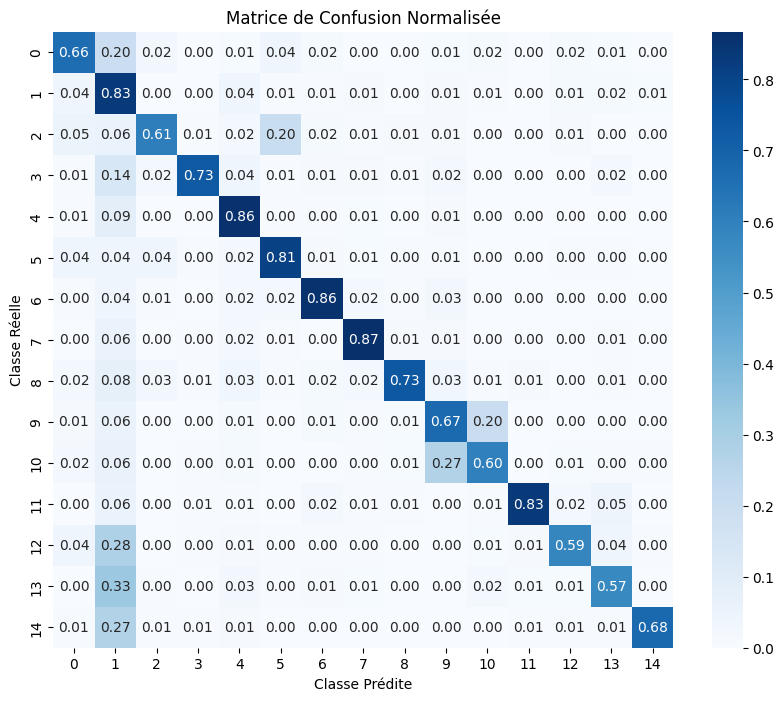

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prédictions
y_pred = model.predict(X_test_embeddings)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Tracer la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
plt.title('Matrice de Confusion Normalisée')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.show()

Au vue des résultats de la matrices de confusion, nous pouvons voir que la classe 1 est la moins bien prédite

### Courbe ROC et AUc

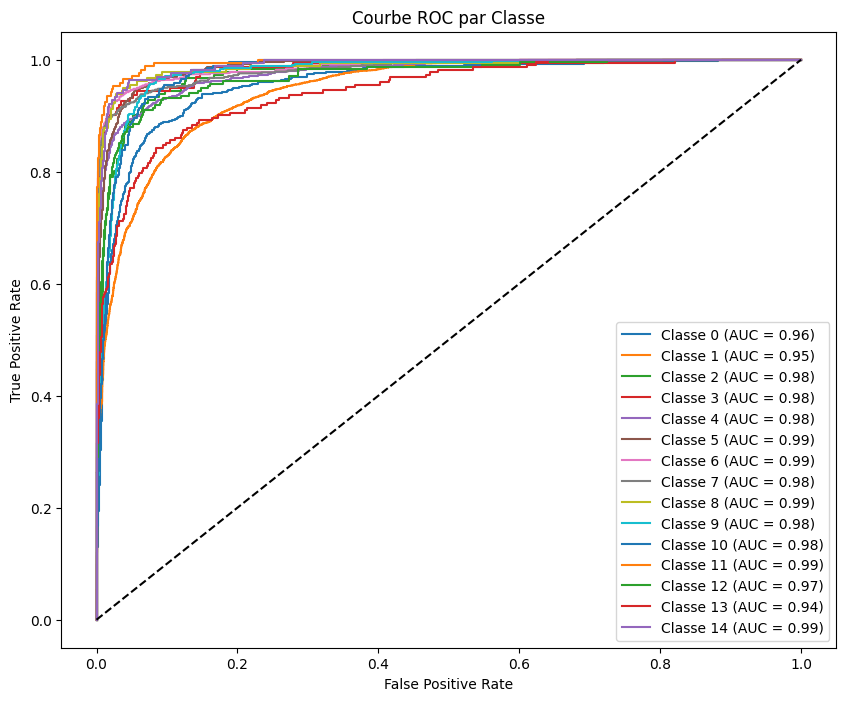

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarisation des étiquettes pour les courbes ROC
y_test_binarized = label_binarize(y_test, classes=range(len(le.classes_)))
n_classes = y_test_binarized.shape[1]

# Calcul des courbes ROC et AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC par Classe')
plt.legend(loc='lower right')
plt.show()

https://www.idbc.fr/tutoriel-comment-lire-une-courbe-roc-et-interpreter-son-auc/

### Courbe de precision et de rappel

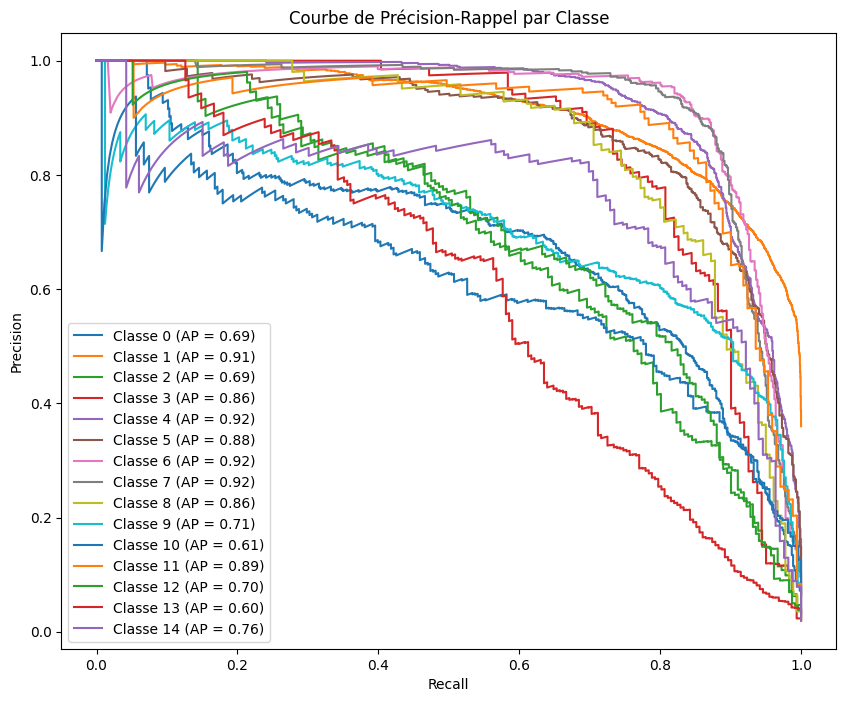

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcul des courbes de précision-rappel et de l'average precision pour chaque classe
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred[:, i])

# Trace des courbes de précision-rappel
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Classe {i} (AP = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe de Précision-Rappel par Classe')
plt.legend(loc='lower left')
plt.show()


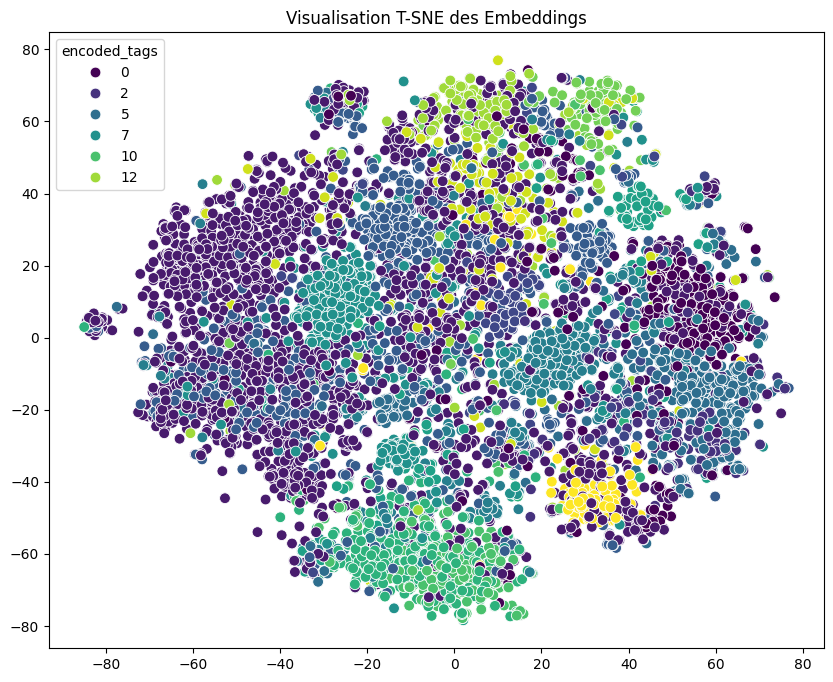

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Réduction de dimension avec T-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_test_embeddings)

# Trace des données réduites avec T-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_test, palette='viridis', s=60)
plt.title('Visualisation T-SNE des Embeddings')
plt.show()

In [ ]:
# # Sauvegarder le modèle
# model.save('modele_use_reseau_neurones.h5')

https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=fr

## Bert

### modèle "bert-base-uncased"

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from transformers import AutoTokenizer, BertTokenizer,DataCollatorForLanguageModeling, Trainer, TrainingArguments, AutoModelForCausalLM
from transformers import TFBertForSequenceClassification, BertTokenizer
from tensorflow.keras.optimizers import Adam
# Bert
import os
import transformers
from transformers import *
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification

os.environ["TF_KERAS"]='1'

c:\Users\bleye\Documents\venv\ia_opcr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\bleye\Documents\venv\ia_opcr\Lib\site-packages\transformers\deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.16.2
2.16.2
Num GPUs Available:  0
False


In [ ]:
# Compter les occurrences de chaque tag
tag_counts = df_bert['new_tags'].value_counts()
tag_counts

new_tags
c#                         6372
java                       3727
c++                        2657
python                     2072
javascript                 1976
                           ... 
base64                        1
shutdown                      1
business-logic                1
windows-error-reporting       1
phpmyadmin                    1
Name: count, Length: 1442, dtype: int64

In [ ]:
top_15_tags_df = tag_counts.head(15).reset_index()

In [ ]:
top_15_tags_df

new_tags  count
0              c#   6372
1            java   3727
2             c++   2657
3          python   2072
4      javascript   1976
5         asp.net   1724
6             php   1640
7             sql   1382
8      sql-server    853
9         windows    754
10              c    712
11           html    630
12  visual-studio    611
13  ruby-on-rails    600
14            wpf    544

In [ ]:
top_15_tags = tag_counts.head(15).index

In [ ]:
# Étape 3 : Filtrer le DataFrame pour ne conserver que les lignes avec ces tags
filtered_df = df_bert[df_bert['new_tags'].isin(top_15_tags)]

In [ ]:
filtered_df.head()

Title  \
0            How to convert Decimal to Double in C#?   
1  Why did the width collapse in the percentage w...   
2  How do I calculate someone's age based on a Da...   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                Body new_tags  
0  <p>I want to assign the decimal variable &quot...       c#  
1  <p>I have an absolutely positioned <code>div</...     html  
2  <p>Given a <code>DateTime</code> representing ...       c#  
3  <p>Given a specific <code>DateTime</code> valu...       c#  
4  <p>Is there a standard way for a web server to...     html

In [ ]:
df_bert.head()

Title  \
0            How to convert Decimal to Double in C#?   
1  Why did the width collapse in the percentage w...   
2  How do I calculate someone's age based on a Da...   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                Body new_tags  
0  <p>I want to assign the decimal variable &quot...       c#  
1  <p>I have an absolutely positioned <code>div</...     html  
2  <p>Given a <code>DateTime</code> representing ...       c#  
3  <p>Given a specific <code>DateTime</code> valu...       c#  
4  <p>Is there a standard way for a web server to...     html

In [ ]:
# df de base sans modification importante (juste filtre 1 tags par ligne)
df_bert.shape

(46388, 3)

In [ ]:
filtered_df.shape

(26254, 3)

In [ ]:
filtered_df.head()

Title  \
0            How to convert Decimal to Double in C#?   
1  Why did the width collapse in the percentage w...   
2  How do I calculate someone's age based on a Da...   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                Body new_tags  
0  <p>I want to assign the decimal variable &quot...       c#  
1  <p>I have an absolutely positioned <code>div</...     html  
2  <p>Given a <code>DateTime</code> representing ...       c#  
3  <p>Given a specific <code>DateTime</code> valu...       c#  
4  <p>Is there a standard way for a web server to...     html

In [ ]:
# concat title and body pour creer une nouvelle colonne "text"
filtered_df['text'] = filtered_df['Title'] + ' ' + filtered_df['Body']


C:\Users\bleye\AppData\Local\Temp\ipykernel_25316\482568310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['Title'] + ' ' + filtered_df['Body']


In [ ]:
filtered_df.head()

Title  \
0            How to convert Decimal to Double in C#?   
1  Why did the width collapse in the percentage w...   
2  How do I calculate someone's age based on a Da...   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                Body new_tags  \
0  <p>I want to assign the decimal variable &quot...       c#   
1  <p>I have an absolutely positioned <code>div</...     html   
2  <p>Given a <code>DateTime</code> representing ...       c#   
3  <p>Given a specific <code>DateTime</code> valu...       c#   
4  <p>Is there a standard way for a web server to...     html   

                                                text  
0  How to convert Decimal to Double in C#? <p>I w...  
1  Why did the width collapse in the percentage w...  
2  How do I calculate someone's age based on a Da...  
3  Calculate relative time in C# <p>Given a speci...  
4  Determine a user's timezone <p>Is there a stan...

In [ ]:
# Etant donner que le modele est très long à entrainer je prend les 8000 premieres lignes
filtered_df = filtered_df.iloc[:8000]

In [ ]:
compte_tags = filtered_df['new_tags'].value_counts()
compte_tags

new_tags
c#               1804
java             1116
c++               758
javascript        603
python            589
asp.net           544
php               493
sql               463
sql-server        346
windows           287
visual-studio     238
html              218
c                 210
ruby-on-rails     192
wpf               139
Name: count, dtype: int64

In [ ]:
# Initialiser LabelEncoder
le = LabelEncoder()

# Encode les tags
filtered_df.loc[:, 'encoded_tags'] = le.fit_transform(filtered_df['new_tags'])

In [ ]:
filtered_df.head()

Title  \
0            How to convert Decimal to Double in C#?   
1  Why did the width collapse in the percentage w...   
2  How do I calculate someone's age based on a Da...   
3                      Calculate relative time in C#   
4                        Determine a user's timezone   

                                                Body new_tags  \
0  <p>I want to assign the decimal variable &quot...       c#   
1  <p>I have an absolutely positioned <code>div</...     html   
2  <p>Given a <code>DateTime</code> representing ...       c#   
3  <p>Given a specific <code>DateTime</code> valu...       c#   
4  <p>Is there a standard way for a web server to...     html   

                                                text  encoded_tags  
0  How to convert Decimal to Double in C#? <p>I w...             2  
1  Why did the width collapse in the percentage w...             4  
2  How do I calculate someone's age based on a Da...             2  
3  Calculate relative time in C# <p>Given a speci...             2  
4  Determine a user's timezone <p>Is there a stan...             4

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [ ]:
# Preprocess the data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_data = tokenizer.batch_encode_plus(
    filtered_df.text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=128, 
    return_tensors='tf'
)

loading file vocab.txt from cache at C:\Users\bleye\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\bleye\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\tokenizer_config.json
loading file tokenizer.json from cache at C:\Users\bleye\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\tokenizer.json
loading configuration file config.json from cache at C:\Users\bleye\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_d

In [ ]:
# Préparation des données : tokenization
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = tf.keras.utils.to_categorical(labels, num_classes=15)

In [ ]:
# Charger le modèle pré-entraîné distilBERT
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=labels.shape[1])

model.classifier.activation = tf.keras.activations.sigmoid

loading configuration file config.json from cache at C:\Users\bleye\.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
   


Loaded 66,362,880 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 

In [ ]:
# Compiler le modèle
model.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entraîner le modèle avec verbose=1
model.fit(
    x={'input_ids': input_ids, 'attention_mask': attention_masks},
    y=labels,
    batch_size=32,
    epochs=5,
    verbose=1
)


Epoch 1/5
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



250/250 [==============================] - 1039s 4s/step - loss: 0.2349 - accuracy: 0.2183
Epoch 2/5
250/250 [==============================] - 985s 4s/step - loss: 0.2286 - accuracy: 0.2226
Epoch 3/5
250/250 [==============================] - 927s 4s/step - loss: 0.2282 - accuracy: 0.2236
Epoch 4/5
250/250 [==============================] - 1071s 4s/step - loss: 0.2282 - accuracy: 0.2229
Epoch 5/5
250/250 [==============================] - 932s 4s/step - loss: 0.2282 - accuracy: 0.2253


In [ ]:
# Évaluer le modèle avec verbose=1
loss, accuracy = model.evaluate(
    x={'input_ids': input_ids, 'attention_mask': attention_masks},
    y=labels,
    verbose=1
)


250/250 [==============================] - 286s 1s/step - loss: 0.2273 - accuracy: 0.2255


In [ ]:
print("Accuracy:", accuracy)

Accuracy: 0.22550000250339508


https://huggingface.co/google-bert/bert-base-uncased